# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [40]:
import io
import os
import numpy as np
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            i = 0
            for line in f:
                word, vec = line.split(' ', 1)
                # Lower word if the lowered version do not exist in vocab 
                # to avoid not having words in vocab for part 2 (with BoW)
                if word.lower() not in self.word2vec:
                    self.word2vec[word.lower()] = np.fromstring(vec, sep=' ')
                    i += 1 
                if i == nmax:
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        words = list(self.word2vec.keys())
        if w in words:
            order = np.argsort([self.score(w, x) for x in words])[-K :][::-1]
            return [words[x] for x in order]
        else:
            print("{} is not in vocabulary".format(w))
            []
            

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        try:
            embed1 = self.word2vec[w1]
            embed2 = self.word2vec[w2]
            return np.dot(embed1, embed2) / (np.linalg.norm(embed1) * np.linalg.norm(embed2))
        except KeyError as e:
            # retrun -1 for words not in dict
            print("{} is not in vocabulary".format(e.args[0]))
            return -1


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7058595452409975
germany berlin 0.7060253015336013
['cat', 'cats', 'kitten', 'feline', 'kitties']
['dog', 'dogs', 'puppy', 'doggie', 'canine']
['dogs', 'dog', 'puppies', 'cats', 'canine']
['paris', 'parisian', 'france', 'marseille', 'louvre']
['germany', 'austria', 'bavaria', 'berlin', 'munich']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                embed = []
                
                # compute the embeding for the different words of sent
                for word in sent.split():
                    try:
                        embed.append(self.w2v.word2vec[word])
                    except KeyError as e:
                        embed.append(np.zeros(list(self.w2v.word2vec.values())[0].shape[0]))
                
                # compute the mean
                sentemb.append(np.mean(embed, axis=0))
            else:
                # idf-weighted mean of word vectors
                embed = []
                
                # compute the idf-weighted embeding for the different words of sent
                for word in sent.split():
                    try:
                        embed.append(idf[word] * self.w2v.word2vec[word])
                    except KeyError as e:
                        embed.append(np.zeros(list(self.w2v.word2vec.values())[0].shape[0]))
                        
                # compute the idf-weighted representation
                sentemb.append(np.mean(embed, axis=0))

        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        # normalization
        keys /= np.linalg.norm(keys, axis=1).reshape(-1, 1)
        query /= np.linalg.norm(query)
        scores = keys.dot(query.T).reshape(-1)
        scores = np.nan_to_num(scores)
        order = np.argsort(scores)[-K :][::-1]
        print("The {} most similar sentences to: '{}' are:".format(K, s))
        for i, x in enumerate(order):
            print("\t {} - {} | {}".format(i+1, sentences[x], scores[x]))

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        embed1 = self.encode([s1], idf)
        embed2 = self.encode([s2], idf)
        if np.linalg.norm(embed1) != 0 and np.linalg.norm(embed2) != 0:
            return float(np.dot(embed1, embed2.T) / (np.linalg.norm(embed1) * np.linalg.norm(embed2)))
        else:
            return 0
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf


In [9]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = [line.rstrip('\n') for line in open("{}/sentences.txt".format(PATH_TO_DATA))]


# Build idf scores for each word
idf = {} if False else s2v.build_idf(sentences)
print("Idf Builded")

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

print()

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 5000 pretrained word vectors
Idf Builded


/home/lawliet/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


The 5 most similar sentences to: '1 smiling african american boy . ' are:
	 1 - 1 smiling african american boy .  | 0.9999999999999999
	 2 - an african american man smiling .  | 0.8693862869350131
	 3 - african american female in a gray dress .  | 0.8171341707934866
	 4 - an african american man playing a saxophone .  | 0.8141442786629289
	 5 - a little african american boy and girl looking up .  | 0.8138854295176445
0.6089445116147134

The 5 most similar sentences to: '1 smiling african american boy . ' are:
	 1 - 1 smiling african american boy .  | 1.0
	 2 - an african american man smiling .  | 0.8756642539700208
	 3 - an african american in sunglasses and a white tee-shirt smiles .  | 0.8598800488850398
	 4 - an african american man playing a saxophone .  | 0.8520591624752151
	 5 - an african american man is sitting .  | 0.8499608262212952


0.5963335652885747

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [16]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
fr_w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), 50000)
en_w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [17]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# Get vocab that exist in both dict
intersecion = [w for w in en_w2v.word2vec if w in fr_w2v.word2vec]
print(len(intersecion))

X = np.array([fr_w2v.word2vec[w] for w in intersecion])
Y = np.array([en_w2v.word2vec[w] for w in intersecion])
print(X.shape, Y.shape)

18970
(18970, 300) (18970, 300)


In [18]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U, sig, Vh = linalg.svd(Y.T.dot(X))
W_fr = U.dot(Vh)

In [20]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

# Define function that returns most similar words to a vector
from itertools import islice
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def most_similar_2_vec(w2v, vec, K=5):
    scores = {word: cosine_sim(rep, vec) for word, rep in w2v.word2vec.items()}
    keys = sorted(scores, key=scores.get, reverse=True)
    return islice(keys, 1, K+1)

# French --> English
french_words = ["chat", "chien", "roi", "france", "porte", "joueur", "pain"]

print("French to english")
for f_word in french_words:
    if f_word in fr_w2v.word2vec:
        words = most_similar_2_vec(en_w2v ,W_fr.dot(fr_w2v.word2vec[f_word]))
        print("The most 5 english similair words to |{}| are: {}".format(f_word, ", ".join(words)))
        
# English --> French
print("English to french")
english_words = ["cat", "dog", "king", "france", "door", "player", "bread"]
W_en = W_fr.T
for e_word in english_words:
    if e_word in en_w2v.word2vec:
        words = most_similar_2_vec(fr_w2v ,W_en.dot(en_w2v.word2vec[e_word]))
        print("The most 5 english similair words to |{}| are: {}".format(e_word, ", ".join(words)))

French to english
The most 5 english similair words to |chat| are: rabbit, hamster, feline, poodle, squirrel
The most 5 english similair words to |chien| are: poodle, terrier, dogs, spaniel, hamster
The most 5 english similair words to |roi| are: vassal, kingship, throne, usurper, reigned
The most 5 english similair words to |france| are: auvergne, luxembourg, french, paris, toulouse
The most 5 english similair words to |porte| are: rue, entrances, entrance, fleurs, gate
The most 5 english similair words to |joueur| are: players, defenceman, winger, footballer, hockey
The most 5 english similair words to |pain| are: dough, butter, flour, breads, lard
English to french
The most 5 english similair words to |cat| are: chat, dog, chats, chien, chatte
The most 5 english similair words to |dog| are: chien, hound, chiens, chienne, chicken
The most 5 english similair words to |king| are: king, rois, reine, trône, queen
The most 5 english similair words to |france| are: espagne, arras, picardie

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [24]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_data(file, test=False):
    with open(PATH_TO_DATA + file, "r") as f:
        lines = f.readlines()
    if not test:
        x = [line[2:].strip() for line in lines]
        y = [int(line[0]) for line in lines]
        return x, np.array(y)
    else:
        return [line.strip() for line in lines]

    
x_train, y_train = load_data('SST/stsa.fine.train', test=False)
x_dev, y_dev = load_data('SST/stsa.fine.dev', test=False)
x_test = load_data('SST/stsa.fine.test.X', test=True)

print("Length of Training data:", len(x_train))
print("Length of Dev data:", len(x_dev))
print("Length of Test data:", len(x_test))

Length of Training data: 8544
Length of Dev data: 1101
Length of Test data: 2210


In [56]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Using the average of words vector gives better results
train_encoded = s2v.encode(x_train)
dev_encoded = s2v.encode(x_dev)
test_encoded = s2v.encode(x_test)

Loaded 5000 pretrained word vectors


In [65]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression as lr

Cs = [0.0001, 0.005, 0.1, 0.2, 0.5, 1, 5, 10, 30]
scores_train = []
scores_dev = []

for c in Cs:
    model = lr(C=c, penalty='l2', multi_class='ovr', solver="liblinear", max_iter=1000)
    model.fit(train_encoded, y_train)
    # Evaluate model on dev data
    score_dev = model.score(dev_encoded, y_dev)
    score_train = model.score(train_encoded, y_train)
    scores_dev.append(score_dev)
    scores_train.append(score_train)
    print("With C={}, train score={} | dev score={}".format(c, score_train, score_dev))

With C=0.0001, train score=0.2717696629213483 | dev score=0.25340599455040874
With C=0.005, train score=0.3252574906367041 | dev score=0.3142597638510445
With C=0.1, train score=0.38857677902621723 | dev score=0.36330608537693004
With C=0.2, train score=0.4028558052434457 | dev score=0.368755676657584
With C=0.5, train score=0.4211142322097378 | dev score=0.3896457765667575
With C=1, train score=0.4324672284644195 | dev score=0.3760217983651226
With C=5, train score=0.44686329588014984 | dev score=0.3851044504995459
With C=10, train score=0.45107677902621723 | dev score=0.38419618528610355
With C=30, train score=0.44932116104868913 | dev score=0.37329700272479566


In [66]:
best_C = Cs[np.argmax(scores)]
print("Train with C={} gives best dev score {}%".format(best_C, round(max(scores_dev) * 100, 2)))

Train with C=0.5 gives best dev score 38.96%


In [58]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
model = lr(C=best_C, penalty='l2', multi_class='ovr', solver="liblinear", max_iter=1000)
model.fit(train_encoded, y_train)
with open("logreg_bov_y_test_sst.txt", "w") as f:
    predictions = model.predict(test_encoded)
    for pred in predictions:
        f.write("{}\n".format(pred))

In [63]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Xgboost gives the best results betwwen SVM and RandomForest

model = XGBClassifier(max_depth=3,n_estimators=300,reg_lambda=1)
model.fit(train_encoded, y_train)
model.score(dev_encoded, y_dev)

0.371480472297911

In [64]:
with open("xgboost_bov_y_test_sst.txt", "w") as f:
    predictions = model.predict(test_encoded)
    for pred in predictions:
        f.write("{}\n".format(pred))

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [8]:
!pip3 install tensorflow-gpu --user
import keras

  Using cached https://files.pythonhosted.org/packages/55/7e/bec4d62e9dc95e828922c6cec38acd9461af8abe749f7c9def25ec4b2fdb/tensorflow_gpu-1.12.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c2/f9/28787754923612ca9bfdffc588daa05580ed70698add063a5629d1a4209d/protobuf-3.6.1-cp36-cp36m-manylinux1_x86_64.whl


Using TensorFlow backend.


In [35]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

# TYPE CODE HERE
def load_data(file, test=False):
    with open(PATH_TO_DATA + file, "r") as f:
        lines = f.readlines()
    if not test:
        x = [line[2:].strip() for line in lines]
        y = [int(line[0]) for line in lines]
        return x, np.array(y)
    else:
        return [line.strip() for line in lines]

    
x_train, y_train = load_data('SST/stsa.fine.train', test=False)
x_dev, y_dev = load_data('SST/stsa.fine.dev', test=False)
x_test = load_data('SST/stsa.fine.test.X', test=True)

print("Length of Training data:", len(x_train))
print("Length of Dev data:", len(x_dev))
print("Length of Test data:", len(x_test))

# To_categorical
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
print("Shape of Y_train", y_train.shape)

Length of Training data: 8544
Length of Dev data: 1101
Length of Test data: 2210
Shape of Y_train (8544, 5)


In [28]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import one_hot

# Number of different words in dict
sentences = x_train + x_dev + x_test
punc = set(['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\n', '\t'])
set_words = set()
for sentence in sentences:
    for word in sentence.split(" "):
        if word not in punc:
            set_words.add(word)
n = len(set_words)

# Creating one hot vectors
x_train_oh = [one_hot(sent, n, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") for sent in x_train]
x_dev_oh = [one_hot(sent, n, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") for sent in x_dev]
x_test_oh = [one_hot(sent, n, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") for sent in x_test]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [32]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences


# 50 is the max length choosen based on the length of different sets
x_train_pad = pad_sequences(x_train_oh, maxlen=50, value=0.0)
x_dev_pad = pad_sequences(x_dev_oh, maxlen=50, value=0.0)
x_test_pad = pad_sequences(x_test_oh, maxlen=50, value=0.0)

## 4.2 - Design and train your model

In [71]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.7, dropout_U=0.7))
model.add(Dense(n_classes, activation='softmax'))

/home/lawliet/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.7, recurrent_dropout=0.7)`


In [72]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          624768    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 649,925
Trainable params: 649,925
Non-trainable params: 0
_________________________________________________________________
None


/home/lawliet/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 8544 samples, validate on 1101 samples
Epoch 1/12
8544/8544 [==============================] - 8s 906us/step - loss: 1.5771 - acc: 0.2660 - val_loss: 1.5715 - val_acc: 0.2534
Epoch 2/12
8544/8544 [==============================] - 7s 762us/step - loss: 1.5649 - acc: 0.2795 - val_loss: 1.5658 - val_acc: 0.2870
Epoch 3/12
8544/8544 [==============================] - 6s 759us/step - loss: 1.5487 - acc: 0.3057 - val_loss: 1.5449 - val_acc: 0.3288
Epoch 4/12
8544/8544 [==============================] - 6s 738us/step - loss: 1.5056 - acc: 0.3392 - val_loss: 1.4978 - val_acc: 0.3361
Epoch 5/12
8544/8544 [==============================] - 6s 741us/step - loss: 1.4495 - acc: 0.3699 - val_loss: 1.4599 - val_acc: 0.3760
Epoch 6/12
8544/8544 [==============================] - 6s 745us/step - loss: 1.3933 - acc: 0.4027 - val_loss: 1.4329 - val_acc: 0.3824
Epoch 7/12
8544/8544 [==============================] - 6s 747us/step - loss: 1.3303 - acc: 0.4340 - val_loss: 1.4173 - val_acc: 0.3860


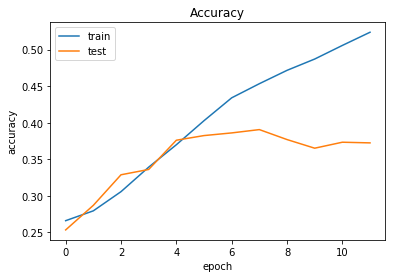

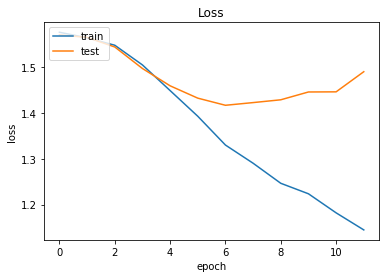

In [73]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
from keras.callbacks import ModelCheckpoint

# ADAPT CODE BELOW
bs = 64
n_epochs = 12

# Save best model
mcp1 = ModelCheckpoint('weights.best.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)
history = model.fit(x_train_pad, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev_pad, y_dev), callbacks = [mcp1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model = keras.models.load_model('weights.best.hdf5')
predictions = model.predict(x_test_pad)
predictions = [np.argmax(pred) for pred in predictions]

with open("logreg_lstm_y_test_sst.txt", "w") as f:
    for pred in predictions:
        f.write("{}\n".format(pred))

## 4.3 -- innovate !

In [ ]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
